Evaluación de clustering k-means

Tiempo estimado: 30 minutos

Objetivos

Al completar este laboratorio, podrás:

Implementar y evaluar el rendimiento del clustering k-means en datos sintéticos.

Interpretar diversas métricas de evaluación y visualizaciones.

Comparar los resultados del clustering con clases conocidas usando datos sintéticos.

Introducción

En este laboratorio, vas a:

Generar datos sintéticos para realizar experimentos específicos usando scikit-learn.

Crear modelos k-means y evaluar su rendimiento comparativo.

Investigar métricas de evaluación y técnicas para valorar los resultados del clustering.

El objetivo principal de este laboratorio es que adquieras intuición sobre el problema subjetivo de encontrar buenas soluciones de clustering.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm

### Función de evaluación de clustering

Definiremos una función para evaluar los modelos de clustering que construiremos.
Incluiremos los puntajes de silhouette y el índice Davies-Bouldin, además de generar un gráfico que muestre los puntajes de silhouette.

In [2]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=''):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.

    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec

    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label) / n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_dict[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Score for {title_suffix} \n' +
                 f'Average Silhouette: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]

    ax.set_yticks([])

## Crear datos sintéticos con cuatro grupos para experimentar con k-means

Aquí crearemos datos sintéticos consistentes en grupos ligeramente superpuestos, y luego ejecutaremos y evaluaremos k-means con k = 4 clusters.

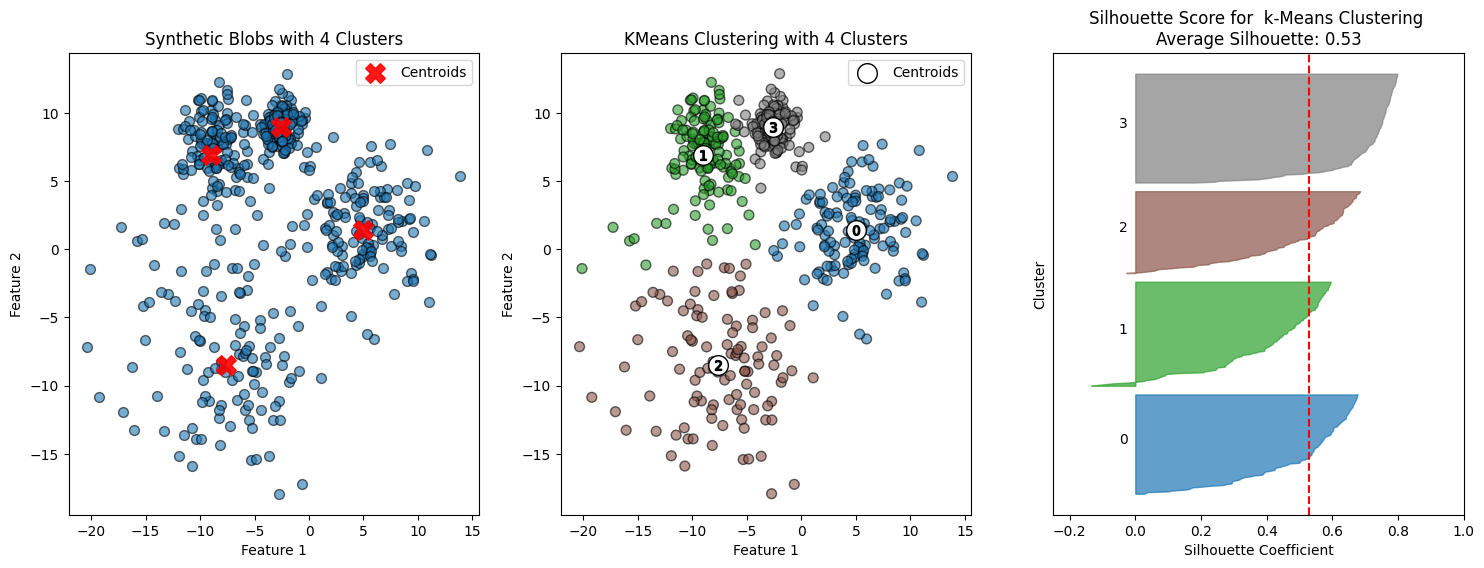

In [3]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[1.0, 3, 5, 2], random_state=42)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot the blobs
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor='k')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', alpha=0.9, label='Centroids')
plt.title(f'Synthetic Blobs with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')

# Label the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
    label='Centroids'
)
# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix=' k-Means Clustering')
plt.show()

Cada punto en un gráfico de silhouette tiene un puntaje de silhouette que varía de -1 a 1.

Un puntaje alto indica que el punto de datos es mucho más similar a su propio cluster que a los clusters vecinos.

Un puntaje cercano a 0 implica que el punto está en o cerca del límite de decisión entre dos clusters.

Un puntaje negativo significa que el punto podría haber sido asignado al cluster incorrecto.
Examinaremos el gráfico de silhouette con más detalle más adelante.

El resultado del clustering es bastante plausible, especialmente porque ya sabemos que hay cuatro grupos en los datos sintéticos. Sin embargo, en la práctica, normalmente no contaríamos con esta información.

## Estabilidad del Clustering

¿Cómo cambian los resultados cuando K-means se ejecuta usando diferentes semillas iniciales para los centroides?

Para evaluar la estabilidad, podemos medir la inercia y variar repetidamente la inicialización aleatoria de los centros de los clusters para observar el impacto de tener diferentes posiciones iniciales de los centroides.

La inercia mide la compacidad de los clusters en K-means. Se define como la suma de las distancias al cuadrado entre cada punto de datos y el centroide de su cluster. Valores más bajos de inercia indican clusters más compactos y, potencialmente, un mejor resultado de clustering. Sin embargo, la inercia tiende a disminuir a medida que aumenta el número de clusters, por lo que es importante interpretarla junto con otras métricas.

Para evaluar la estabilidad del clustering, ejecutar k-means varias veces con diferentes centroides iniciales (sin fijar el estado aleatorio) ayuda a determinar si el algoritmo produce consistentemente asignaciones de clusters y puntajes de inercia similares. Una inercia consistente entre ejecuciones sugiere una solución estable que depende menos de las posiciones iniciales de los centroides.

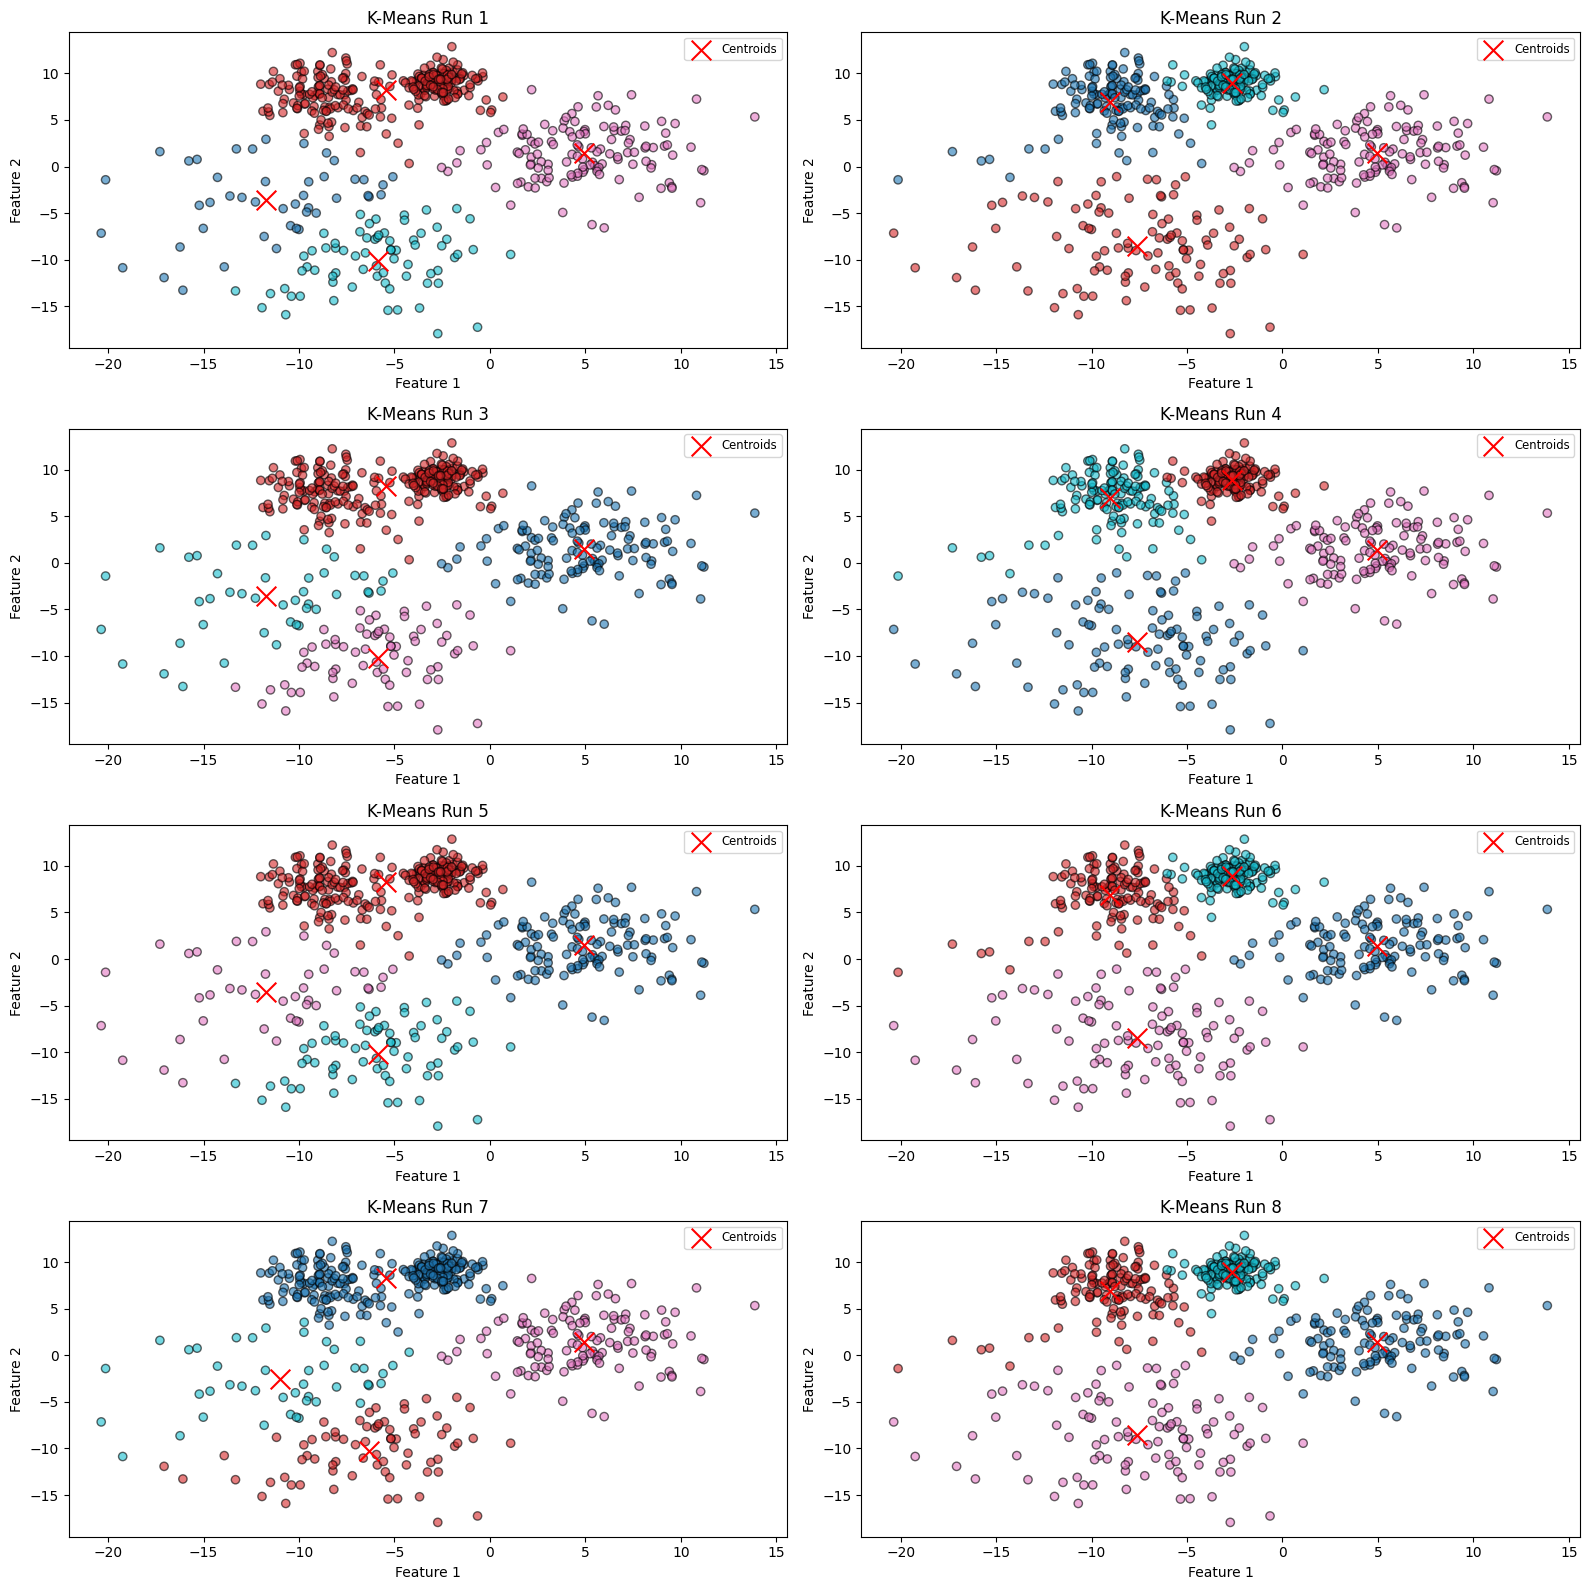

Run 1: Inertia=8575.44
Run 2: Inertia=7633.51
Run 3: Inertia=8575.44
Run 4: Inertia=7633.51
Run 5: Inertia=8575.44
Run 6: Inertia=7633.51
Run 7: Inertia=8556.67
Run 8: Inertia=7633.51


In [4]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2 # Number of columns
n_rows = -(-n_runs // n_cols) # Ceil division to determine rows
plt.figure(figsize=(16, 16)) # Adjust the figure size for better visualization

# Run K-Means multiple times with different random states
for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=None)  # Use the default `n_init`
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

    # Plot the clustering result
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.6, edgecolor='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Centroids')
    plt.title(f'K-Means Run {i + 1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
    print(f'Run {i}: Inertia={inertia:.2f}')

### Ejercicio 1. ¿Qué puedes decir sobre este resultado?


Como se muestra en los resultados del clustering, las asignaciones de clusters varían entre ejecuciones al usar diferentes semillas iniciales para los centroides. Además, los valores de inercia muestran inconsistencias, lo que indica que el proceso de clustering es sensible a la ubicación inicial de los centroides. Esta inconsistencia en la inercia implica un resultado menos confiable.

## Número de clusters

¿Cómo cambian las métricas de rendimiento a medida que aumenta el número de clusters?

¿Puede este análisis ayudarte a determinar el número óptimo de clusters?

Para explorar esto, podemos examinar cómo variar el valor de K afecta métricas clave como la inercia, el índice Davies-Bouldin y los puntajes de silhouette. Al graficar estas métricas en función de K, podemos analizar los resultados y, potencialmente, obtener información sobre el número óptimo de clusters para nuestros datos.

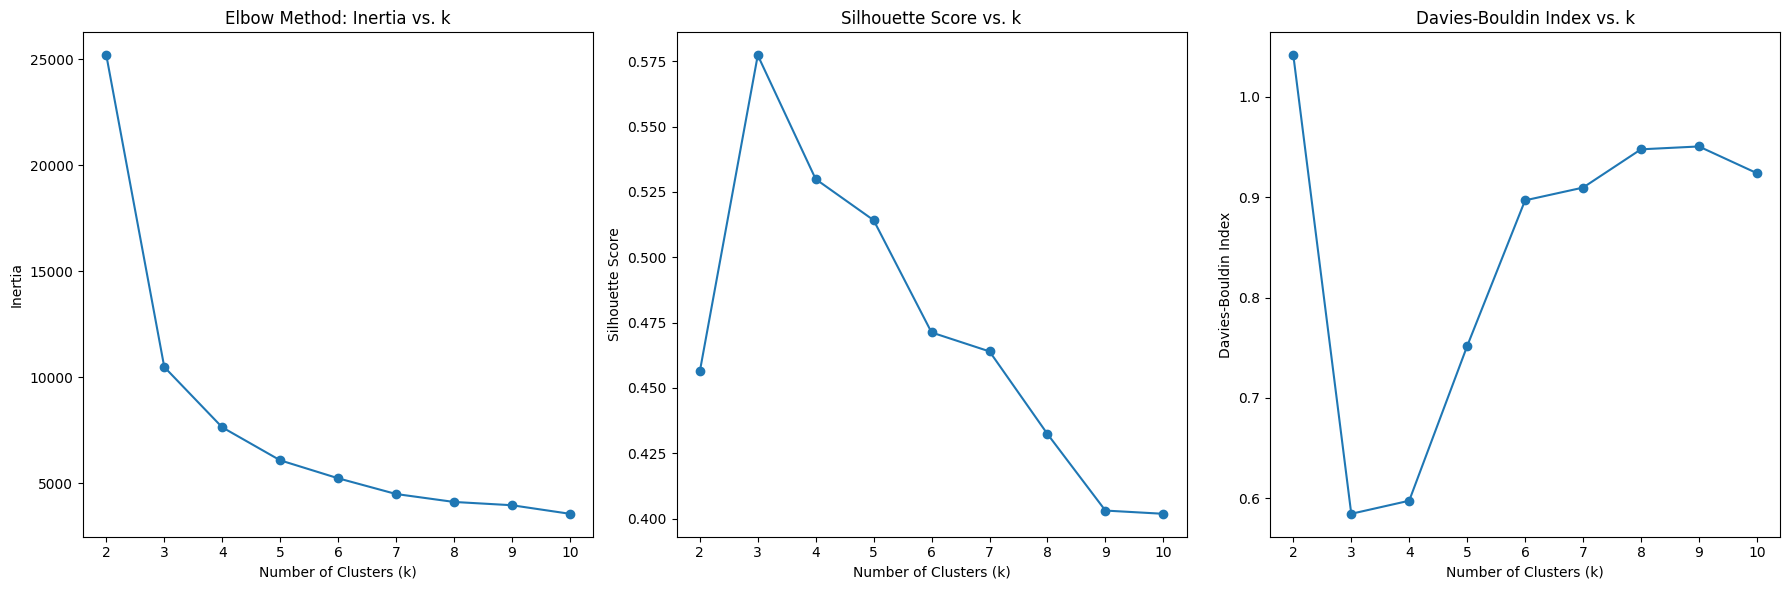

In [5]:
# Range of k values to test
k_values = range(2, 11)

# Store performance metrics
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Calculate and store metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X, y_kmeans))

# Plot the inertia values (Elbow Method)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Inertia vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker='o')
plt.title('Davies-Bouldin Index vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

### Ejercicio 2. ¿Qué te sugieren estos resultados?


El primer gráfico se utiliza a menudo en el método del codo, donde el valor ideal de k se elige cerca del punto donde la curva comienza a nivelarse. Dado que la inercia disminuye a medida que aumenta el número de clusters, es importante encontrar un equilibrio donde agregar más clusters proporcione rendimientos decrecientes en la reducción de la inercia.

El gráfico de inercia apunta a un número óptimo de clusters alrededor de 3 o 4. El puntaje de silhouette muestra un pico claro en k = 3, mientras que el índice Davies-Bouldin alcanza sus valores más bajos entre k = 3 y k = 4.

En general, estas métricas sugieren que tres clusters pueden ser óptimos, aunque sabemos que el número real de clusters en este caso es en realidad cuatro.

### Ejercicio 3. Grafica los blobs y los resultados del clustering para **k = 3, 4 y 5**


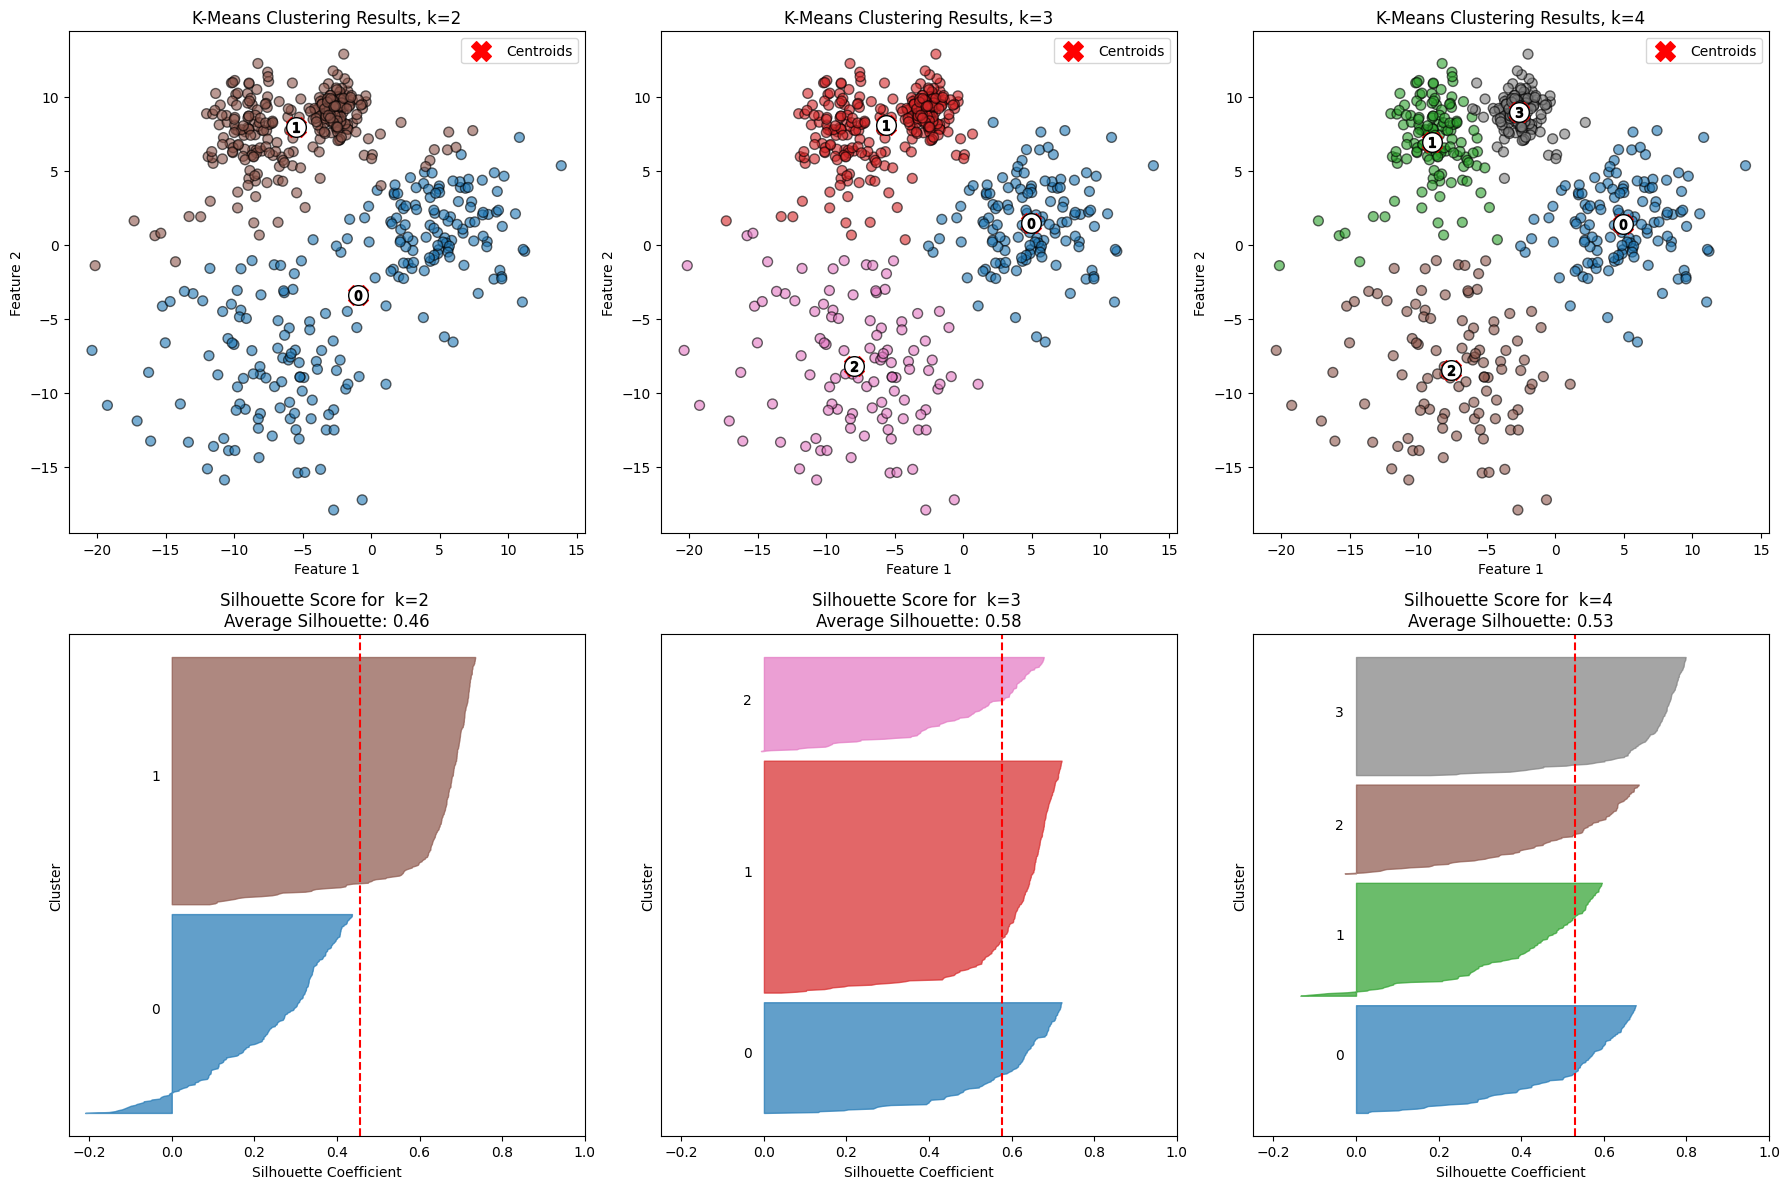

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plt.figure(figsize=(18, 12))
colormap = cm.tab10

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict the labels
    kmeans = KMeans(n_clusters=k, random_state=42)  # Replace '...' with k
    y_kmeans = kmeans.fit_predict(X)               # Replace '...' with X

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float) / k)

    # Scatter plot for each k in the first row
    ax1 = plt.subplot(2, 3, i + 1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
    ax1.scatter(kmeans.cluster_centers_[:, 0],
                kmeans.cluster_centers_[:, 1],
                c='red', s=200, marker='X', label='Centroids')

    # Draw white circles at cluster centers
    centers = kmeans.cluster_centers_
    ax1.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k"
    )

    # Label clusters with numbers
    for idx, c in enumerate(centers):
        ax1.scatter(c[0], c[1], marker=f"${idx}$", alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f' k={k}')

plt.tight_layout()
plt.show()

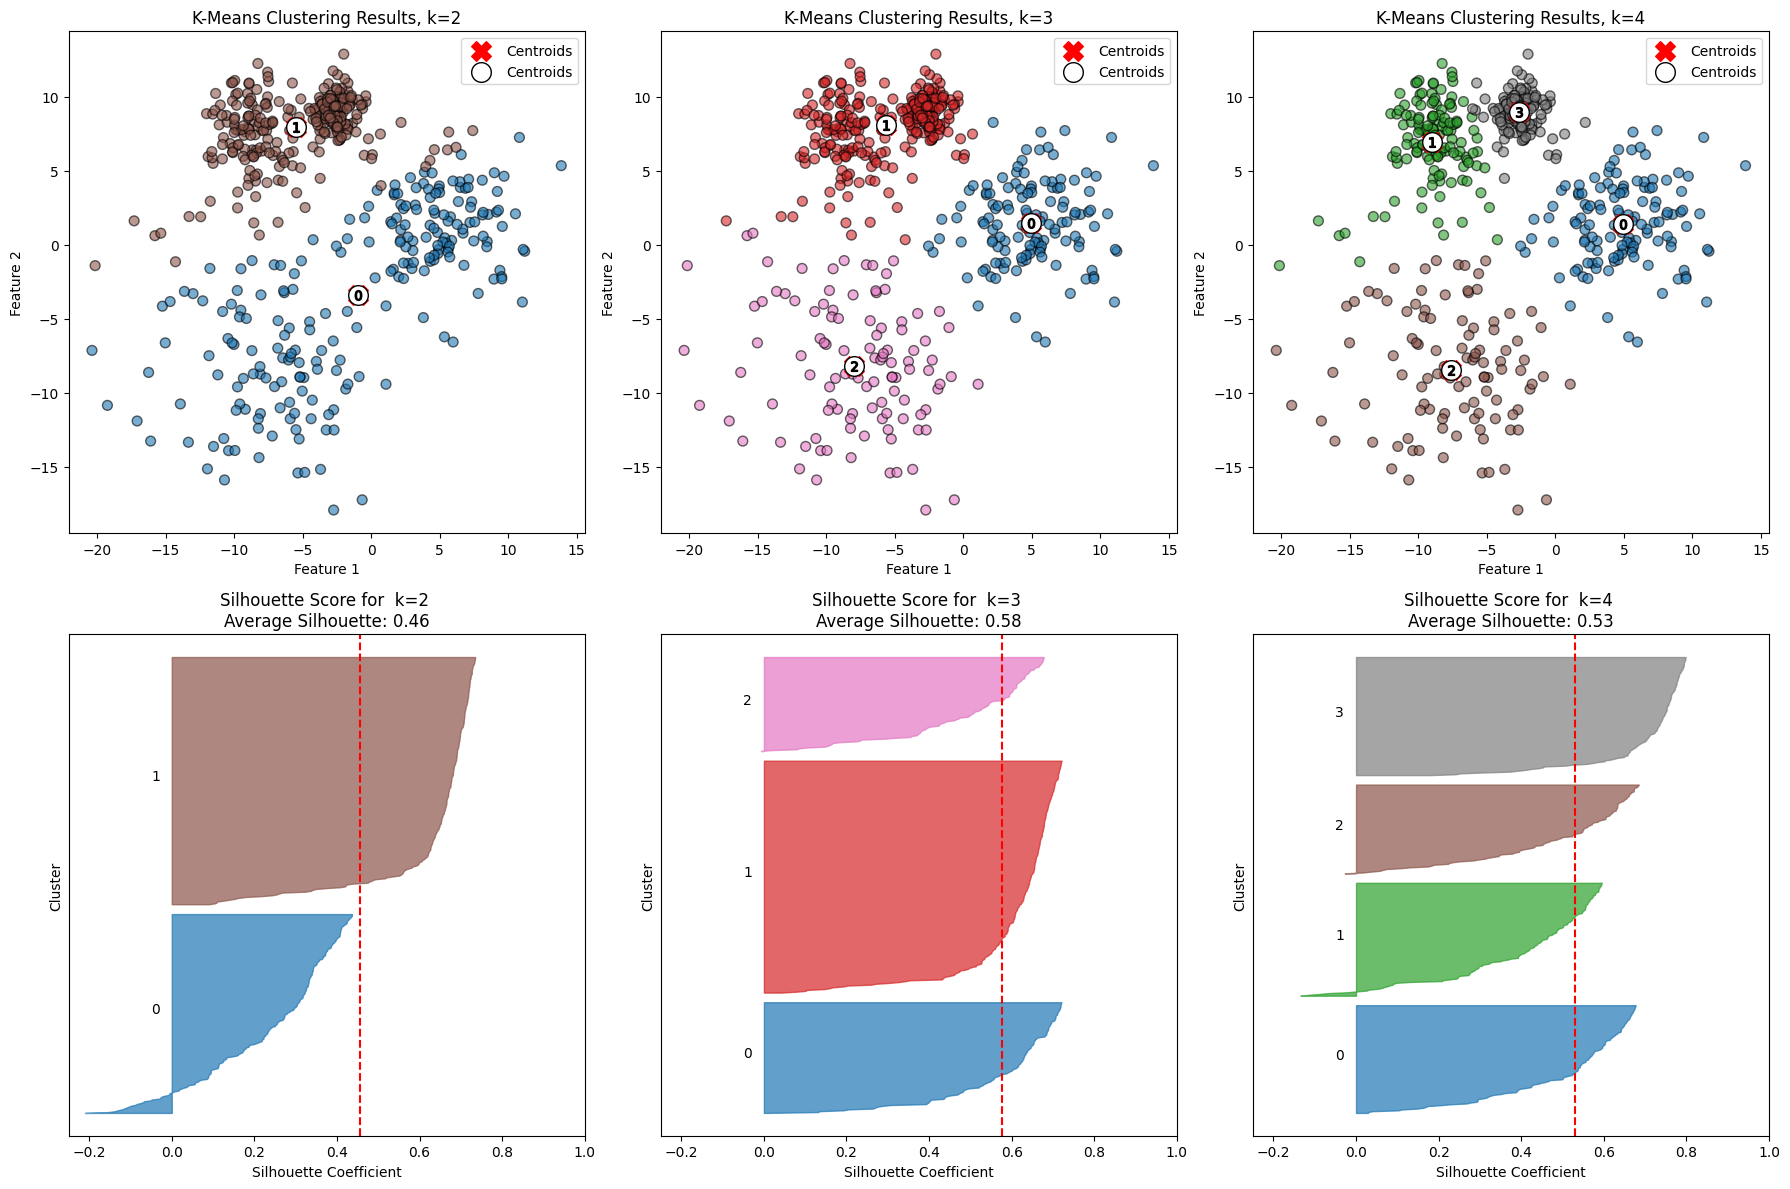

In [7]:
plt.figure(figsize=(18, 12))
colormap = cm.tab10  # Define the colormap

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict labels
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float) / k)

    # Scatter plot for each k in the first row (1, 2, 3)
    ax1 = plt.subplot(2, 3, i + 1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
        label='Centroids'
    )

    for i_, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker="$%d$" % i_, alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row (4, 5, 6)
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f' k={k}')

plt.tight_layout()  # Adjust spacing between plots
plt.show()

## Ejercicio 4. ¿Son estos resultados consistentes con nuestros resultados anteriores, donde analizamos los gráficos de métricas de evaluación en función de k?


Al examinar los resultados del clustering para k = 2, 3 y 4, se hace evidente que la elección intuitiva para el número óptimo de clusters es cuatro, aunque también podría argumentarse a favor de tres. Para k = 3, el primer cluster no logra distinguir entre dos regiones con densidades diferentes, mientras que para k = 4, estas regiones se dividen en dos clusters distintos (clusters 1 y 3).

El gráfico de silhouette para k = 4 muestra anchos de bloque relativamente uniformes entre los clusters, lo que sugiere clusters de tamaños similares. Sin embargo, la forma de estos bloques indica que muchos puntos están asignados de manera algo ambigua, lo que resalta que los clusters no están claramente separados y pueden superponerse en cierta medida.

Determinar el número “correcto” de clusters no es sencillo, ya que a menudo implica juicio subjetivo. Las métricas por sí solas señalan k = 3 como óptimo, dado que el gráfico de silhouette para k = 3 muestra una mejor separación de clusters, con puntajes de silhouette más altos y consistentes entre los clusters en comparación con otras elecciones de k.

### Limitaciones de k-means - Sensibilidad a la forma

¿Puedes identificar situaciones en las que K-means no sería adecuado? ¿Qué alternativas podrían utilizarse?

Vamos a explorar estas preguntas con un experimento. Usando make_classification, crearemos un conjunto de datos 2D etiquetado que consiste en tres clases. Esta vez tendremos conjuntos de puntos con formas diferentes en cada clase, no solo blobs esféricos.

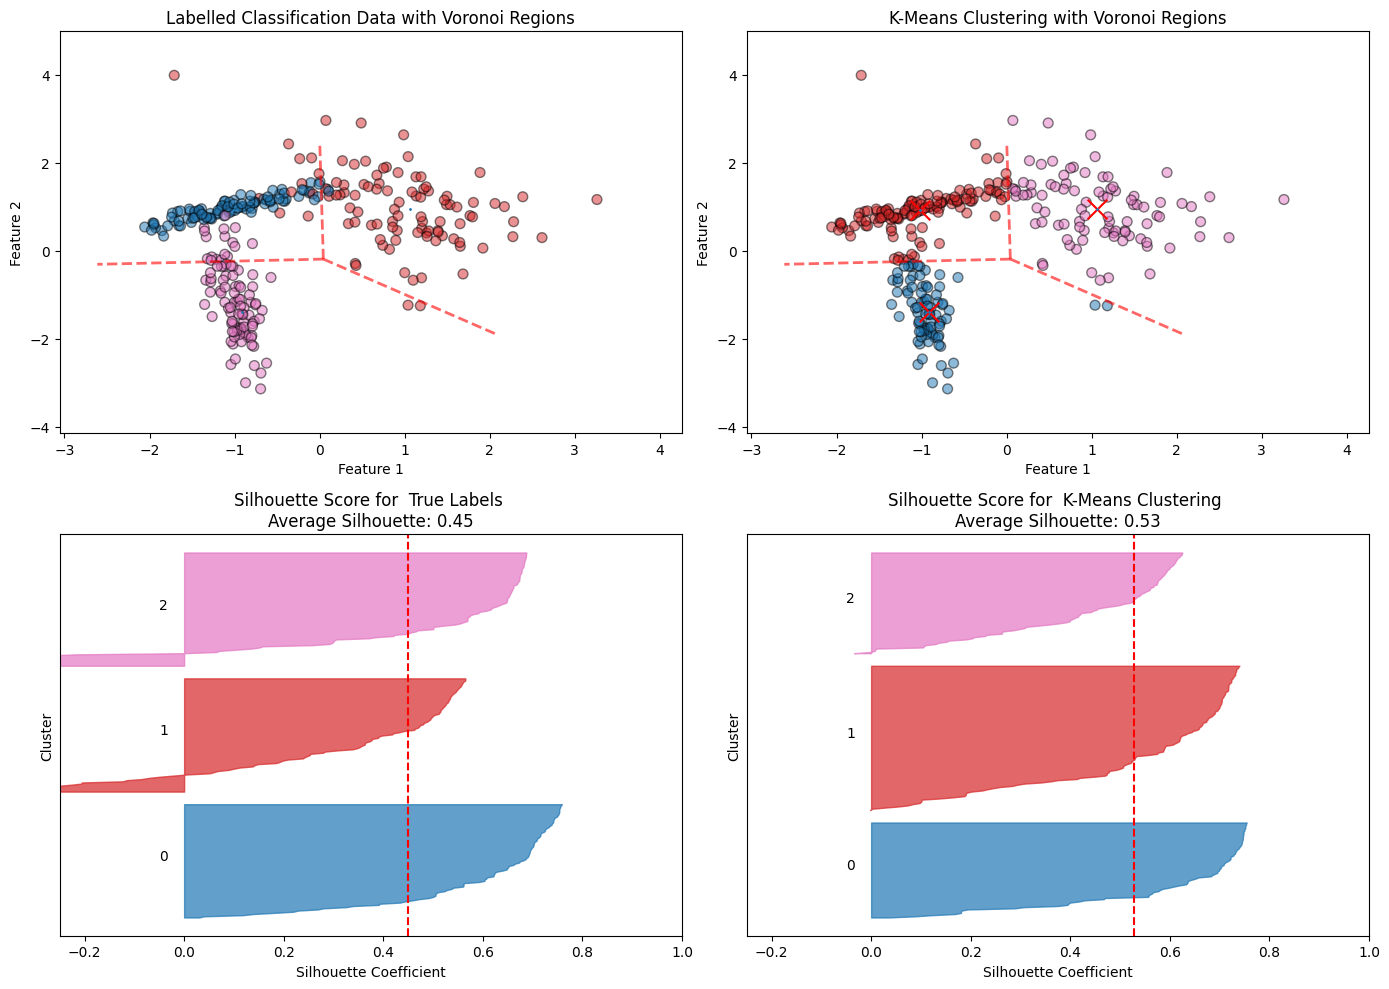

In [8]:
# Generate synthetic classification data
X, y_true = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0,
                                n_clusters_per_class=1, n_classes=3, random_state=42)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Compute the Voronoi diagram
vor = Voronoi(centroids)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get consistent axis limits for all scatter plots
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Plot the true labels with Voronoi regions
colormap = cm.tab10
colors_true = colormap(y_true.astype(float) / 3)
axes[0, 0].scatter(X[:, 0], X[:, 1], c=colors_true, s=50, alpha=0.5, ec='k')
voronoi_plot_2d(vor, ax=axes[0, 0], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)
axes[0, 0].set_title('Labelled Classification Data with Voronoi Regions')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].set_ylim(y_min, y_max)

# Call evaluate_clustering for true labels
evaluate_clustering(X, y_true, n_clusters=3, ax=axes[1, 0], title_suffix=' True Labels')

# Plot K-Means clustering results with Voronoi regions
colors_kmeans = colormap(y_kmeans.astype(float) / 3)
axes[0, 1].scatter(X[:, 0], X[:, 1], c=colors_kmeans, s=50, alpha=0.5, ec='k')
axes[0, 1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
voronoi_plot_2d(vor, ax=axes[0, 1], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)

axes[0, 1].set_title('K-Means Clustering with Voronoi Regions')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].set_ylim(y_min, y_max)

# Call evaluate_clustering for K-Means labels
evaluate_clustering(X, y_kmeans, n_clusters=3, ax=axes[1, 1], title_suffix=' K-Means Clustering')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Ejercicio 5. ¿Qué puedes decir sobre este resultado?

¿Qué tan bien replicó k-means las clases en este experimento? ¿Cuáles son algunas consideraciones al usar enfoques diferentes?

K-means hizo un buen trabajo identificando tres clusters que en su mayoría coinciden con las tres clases reales. Sin embargo, al analizar más detalladamente, se observa que K-means no captura completamente la coherencia inherente de las dos clases con forma lineal (representadas en púrpura y verde).

Otro aspecto a destacar es que los clusters están particionados de manera que no refleja la densidad de las clases.

Las líneas rojas discontinuas en los gráficos de dispersión indican los límites entre las regiones "Voronoi" que separan los clusters. Este método de partición asume formas esféricas para los clusters y puede clasificar incorrectamente puntos cuando la distribución real es curva o lineal. Por ejemplo, algunos puntos de la clase púrpura alargada fueron mal etiquetados, cayendo en la sección inferior del cluster más esférico. De manera similar, algunos puntos verdes entre los clusters verde y púrpura también fueron etiquetados incorrectamente.

Curiosamente, el puntaje de silhouette es más alto para el resultado del clustering que para las etiquetas de clase reales. Esto tiene sentido, ya que las clases reales se superponen ligeramente, como también se indica por los valores negativos en el gráfico de silhouette para las clases rosa y roja.

Un enfoque de clustering más flexible, como DBSCAN (Density-Based Spatial Clustering of Applications with Noise), podría ser más adecuado para este tipo de datos. DBSCAN considera la densidad y puede identificar clusters de formas y tamaños variados, capturando de manera más efectiva la estructura real de los datos.

En problemas de clustering del mundo real, no se conoce la verdad subyacente, por lo que es esencial explorar múltiples algoritmos y adaptarlos a las características específicas de los datos. Probar métodos diferentes como DBSCAN o clustering jerárquico, que consideran la densidad y la proximidad de manera no lineal, podría ofrecer mejores resultados para conjuntos de datos complejos.